In [8]:
from agent import app, get_arxiv_paper_details

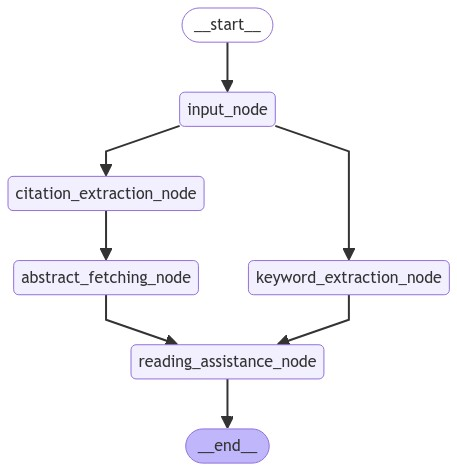

In [9]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
url = "https://arxiv.org/pdf/2310.04406"
response = await app.ainvoke({"paper_url": url})

In [ ]:
response

In [4]:
json = {'citations': [{'authors': ['T. Silver',
    'A. Huang',
    'C. J. Maddison',
    'A. Guez',
    'L. Sifre',
    'G. van den Driessche',
    'J. Schrittwieser',
    'I. Antonoglou',
    'V. Panneershelvam',
    'M. Lanctot',
    'S. Dieleman',
    'D. Grewe',
    'J. Nham',
    'N. Kalchbrenner',
    'I. Sutskever',
    'T. P. Lillicrap',
    'M. Leach',
    'K. Kavukcuoglu',
    'T. Graepel',
    'D. Hassabis'],
   'title': 'Mastering the game of Go with deep neural networks and tree search',
   'year': 2016},
  {'authors': ['D. Silver',
    'A. Huang',
    'C. J. Maddison',
    'A. Guez',
    'L. Sifre',
    'G. van den Driessche',
    'J. Schrittwieser',
    'I. Antonoglou',
    'V. Panneershelvam',
    'M. Lanctot',
    'S. Dieleman',
    'D. Grewe',
    'J. Nham',
    'N. Kalchbrenner',
    'I. Sutskever',
    'T. P. Lillicrap',
    'M. Leach',
    'K. Kavukcuoglu',
    'T. Graepel',
    'D. Hassabis'],
   'title': 'Mastering chess and Shogi by self-play with a general reinforcement learning algorithm',
   'year': 2017},
  {'authors': ['M. Campbell', 'A. J. Hoane Jr', 'F. Hsu'],
   'title': 'Deep blue',
   'year': 2002},
  {'authors': ['B. Chen',
    'F. Zhang',
    'A. Nguyen',
    'D. Zan',
    'Z. Lin',
    'J. Lou',
    'W. Chen'],
   'title': 'CodeT: Code generation with generated tests',
   'year': 2023},
  {'authors': ['M. Chen',
    'J. Tworek',
    'H. Jun',
    'Q. Yuan',
    'H. Ponde',
    'J. Kaplan',
    'H. Edwards',
    'Y. Burda',
    'N. Joseph',
    'G. Brockman',
    'A. Ray',
    'R. Puri',
    'G. Krueger',
    'M. Petrov',
    'H. Khlaaf',
    'G. Sastry',
    'P. Mishkin',
    'B. Chan',
    'S. Gray',
    'N. Ryder',
    'M. Bavarian',
    'C. Berner',
    'S. McCandlish',
    'A. Radford',
    'I. Sutskever',
    'W. Zaremba'],
   'title': 'Evaluating large language models trained on code',
   'year': 2021},
  {'authors': ['W. Chen', 'X. Ma', 'X. Wang', 'W. W. Cohen'],
   'title': 'Program of thoughts prompting: disentangling computation from reasoning for numerical reasoning tasks',
   'year': 2023},
  {'authors': ['A. Chowdhery',
    'S. Narang',
    'J. Devlin',
    'M. Bosma',
    'G. Mishra',
    'A. Roberts',
    'P. Barham',
    'H. W. Chung',
    'C. Sutton',
    'S. Gehrmann',
    'P. Schuh',
    'K. Shi',
    'S. Tsvyashchenko',
    'J. Maynez',
    'A. Rao',
    'P. Barnes',
    'Y. Tay',
    'N. Shazeer',
    'V. Prabhakaran',
    'N. Du',
    'B. Hutchinson',
    'R. Pope',
    'J. Bradbury',
    'J. Austin',
    'M. Isard',
    'G. Gur-Ari',
    'P. Yin',
    'T. Duke',
    'A. Lewkowycz',
    'S. Zhang',
    'Y. Bengio',
    'W. W. Cohen',
    'R. Salakhutdinov',
    'C. D. Manning'],
   'title': 'PaLM: Scaling language modeling with pathways',
   'year': 2023},
  {'authors': ['K. Cobbe',
    'V. Kosaraju',
    'M. Bavarian',
    'M. Chen',
    'H. Jun',
    'L. Kaiser',
    'M. Plappert',
    'J. Tworek',
    'J. Hilton',
    'R. Nakano',
    'C. Hesse',
    'J. Schulman'],
   'title': 'Training verifiers to solve math word problems',
   'year': 2021},
  {'authors': ['X. Deng',
    'Y. Gu',
    'B. Zheng',
    'S. Chen',
    'S. Stevens',
    'B. Wang',
    'H. Sun',
    'Y. Su'],
   'title': 'Mind2Web: Towards a generalist agent for the web',
   'year': 2023},
  {'authors': ['D. Driess',
    'F. Xia',
    'M. S. M. Sajjadi',
    'C. Lynch',
    'A. Chowdhery',
    'B. Ichter',
    'A. Wahid',
    'J. Tompson',
    'Q. Vuong',
    'T. Yu',
    'W. Huang',
    'Y. Chebotar',
    'P. Sermanet',
    'D. Duckworth',
    'S. Levine',
    'V. Vanhoucke',
    'K. Hausman',
    'M. Toussaint',
    'K. Greff',
    'A. Zeng',
    'I. Mordatch',
    'P. Florence'],
   'title': 'PaLM-E: An embodied multimodal language model',
   'year': 2023},
  {'authors': ['Y. Du',
    'M. Yang',
    'B. Dai',
    'H. Dai',
    'O. Nachum',
    'J. B. Tenenbaum',
    'D. Schuurmans',
    'P. Abbeel'],
   'title': 'Learning universal policies via text-guided video generation',
   'year': 2023},
  {'authors': ['J. S. B. T. Evans'],
   'title': 'Intuition and reasoning: A dual-process perspective',
   'year': 2010},
  {'authors': ['L. Fan',
    'G. Wang',
    'Y. Jiang',
    'A. Mandlekar',
    'Y. Zhu',
    'H. Zhang',
    'D. Huang',
    'A. Anandkumar'],
   'title': 'MineDojo: Building open-ended embodied agents with internet-scale knowledge',
   'year': 2022},
  {'authors': ['H. Furuta',
    'O. Nachum',
    'K. Lee',
    'Y. Matsuo',
    'S. S. Gu',
    'I. Gur'],
   'title': 'Multimodal web navigation with instruction-finetuned foundation models',
   'year': 2024},
  {'authors': ['L. Gao',
    'A. Madaan',
    'S. Zhou',
    'U. Alon',
    'P. Liu',
    'Y. Yang',
    'J. Callan',
    'G. Neubig'],
   'title': 'PAL: Program-aided language models',
   'year': 2023},
  {'authors': ['J. Guo', 'S. Lu', 'H. Cai', 'W. Zhang', 'Y. Yu', 'J. Wang'],
   'title': 'Long text generation via adversarial training with leaked information',
   'year': 2018},
  {'authors': ['W. H. Guss',
    'B. Houghton',
    'N. Topin',
    'P. Wang',
    'C. Codel',
    'M. Veloso',
    'R. Salakhutdinov'],
   'title': 'MineRL: A large-scale dataset of Minecraft demonstrations',
   'year': 2019},
  {'authors': ['D. Hafner',
    'T. Lillicrap',
    'I. Fischer',
    'R. Villegas',
    'D. Ha',
    'H. Lee',
    'J. Davidson'],
   'title': 'Learning latent dynamics for planning from pixels',
   'year': 2019},
  {'authors': ['D. Hafner', 'J. Pasukonis', 'J. Ba', 'T. Lillicrap'],
   'title': 'Mastering diverse domains through world models',
   'year': 2023},
  {'authors': ['S. Hao',
    'Y. Gu',
    'H. Ma',
    'J. J. Hong',
    'Z. Wang',
    'D. Z. Wang',
    'Z. Hu'],
   'title': 'Reasoning with language model is planning with world model',
   'year': 2023},
  {'authors': ['J. Huang',
    'X. Chen',
    'S. Mishra',
    'H. S. Zheng',
    'A. W. Yu',
    'X. Song',
    'D. Zhou'],
   'title': 'Large language models cannot self-correct reasoning yet',
   'year': 2024},
  {'authors': ['W. Huang',
    'F. Xia',
    'T. Xiao',
    'H. Chan',
    'J. Liang',
    'P. R. Florence',
    'A. Zeng',
    'J. Tompson',
    'I. Mordatch',
    'Y. Chebotar',
    'P. Sermanet',
    'N. Brown',
    'T. Jackson',
    'L. Luu',
    'S. Levine',
    'K. Hausman',
    'M. Toussaint',
    'K. Greff',
    'A. Zeng',
    'I. Mordatch',
    'P. Florence'],
   'title': 'Inner monologue: Embodied reasoning through planning with language models',
   'year': 2022},
  {'authors': ['L. Kocsis', 'C. Szepesvari'],
   'title': 'Bandit based monte-carlo planning',
   'year': 2006},
  {'authors': ['S. M. LaValle'],
   'title': 'Rapidly-exploring random trees: A new tool for path planning',
   'year': 1998},
  {'authors': ['E. Z. Liu', 'K. Guu', 'P. Pasupat', 'T. Shi', 'P. Liang'],
   'title': 'Reinforcement learning on web interfaces using workflow-guided exploration',
   'year': 2018},
  {'authors': ['X. Liu',
    'H. Yu',
    'H. Zhang',
    'Y. Xu',
    'X. Lei',
    'H. Lai',
    'Y. Gu',
    'H. Ding',
    'K. Men',
    'K. Yang',
    'S. Zhang',
    'X. Deng',
    'A. Zeng',
    'Z. Du',
    'C. Zhang',
    'S. Shen',
    'T. Zhang',
    'Y. Su',
    'H. Sun',
    'M. Huang',
    'Y. Dong',
    'J. Tang'],
   'title': 'AgentBench: Evaluating LLMs as agents',
   'year': 2024},
  {'authors': ['Z. Liu',
    'H. Hu',
    'S. Zhang',
    'H. Guo',
    'S. Ke',
    'B. Liu',
    'Z. Wang'],
   'title': 'Reason for future, act for now: A principled framework for autonomous LLM agents with provable sample efficiency',
   'year': 2023},
  {'authors': ['A. Madaan',
    'N. Tandon',
    'P. Gupta',
    'S. Hallinan',
    'L. Gao',
    'S. Wiegreffe',
    'U. Alon',
    'N. Dziri',
    'S. Prabhumoye',
    'Y. Yang',
    'S. Gupta',
    'B. P. Majumder',
    'K. Hermann',
    'S. Welleck',
    'A. Yazdanbakhsh',
    'P. Clark'],
   'title': 'Self-refine: Iterative refinement with self-feedback',
   'year': 2023},
  {'authors': ['R. Nallapati',
    'B. Zhou',
    'C. dos Santos',
    'C. Gulcehre',
    'B. Xiang'],
   'title': 'Abstractive text summarization using sequence-to-sequence RNNs and beyond',
   'year': 2016},
  {'authors': ['OpenAI'], 'title': 'GPT-4 technical report', 'year': 2023},
  {'authors': ['Y. Qin',
    'S. Liang',
    'Y. Ye',
    'K. Zhu',
    'L. Yan',
    'Y. Lu',
    'Y. Lin',
    'X. Cong',
    'X. Tang',
    'B. Qian',
    'S. Zhao',
    'R. Tian',
    'R. Xie',
    'J. Zhou',
    'M. Gerstein',
    'D. Li',
    'Z. Liu',
    'M. Sun'],
   'title': 'ToolLLM: Facilitating large language models to master 16000+ real-world APIs',
   'year': 2024},
  {'authors': ['A. Saparov', 'H. He'],
   'title': 'Language models are greedy reasoners: A systematic formal analysis of chain-of-thought',
   'year': 2023},
  {'authors': ['T. Schick',
    'J. Dwivedi-Yu',
    'R. Dess`ı',
    'R. Raileanu',
    'M. Lomeli',
    'L. Zettlemoyer',
    'N. Cancedda',
    'T. Scialom'],
   'title': 'Toolformer: Language models can teach themselves to use tools',
   'year': 2023},
  {'authors': ['Y. Shen', 'K. Song', 'X. Tan', 'D. Li', 'W. Lu', 'Y. Zhuang'],
   'title': 'HuggingGPT: Solving AI tasks with ChatGPT and its friends in Hugging Face',
   'year': 2023},
  {'authors': ['N. Shinn',
    'F. Cassano',
    'B. Labash',
    'A. Gopinath',
    'K. Narasimhan',
    'S. Yao'],
   'title': 'Reflexion: Language agents with verbal reinforcement learning',
   'year': 2023},
  {'authors': ['M. Shridhar',
    'X. Yuan',
    'M. Cotˆ e',
    'Y. Bisk',
    'A. Trischler',
    'M. Hausknecht'],
   'title': 'ALFWorld: Aligning text and embodied environments for interactive learning',
   'year': 2020},
  {'authors': ['D. Silver',
    'A. Huang',
    'C. J. Maddison',
    'A. Guez',
    'L. Sifre',
    'G. van den Driessche',
    'J. Schrittwieser',
    'I. Antonoglou',
    'V. Panneershelvam',
    'M. Lanctot',
    'S. Dieleman',
    'D. Grewe',
    'J. Nham',
    'N. Kalchbrenner',
    'I. Sutskever',
    'T. P. Lillicrap',
    'M. Leach',
    'K. Kavukcuoglu',
    'T. Graepel',
    'D. Hassabis'],
   'title': 'Mastering the game of Go with deep neural networks and tree search',
   'year': 2016},
  {'authors': ['D. Silver',
    'A. Huang',
    'C. J. Maddison',
    'A. Guez',
    'L. Sifre',
    'G. van den Driessche',
    'J. Schrittwieser',
    'I. Antonoglou',
    'V. Panneershelvam',
    'M. Lanctot',
    'S. Dieleman',
    'D. Grewe',
    'J. Nham',
    'N. Kalchbrenner',
    'I. Sutskever',
    'T. P. Lillicrap',
    'M. Leach',
    'K. Kavukcuoglu',
    'T. Graepel',
    'D. Hassabis'],
   'title': 'Mastering chess and Shogi by self-play with a general reinforcement learning algorithm',
   'year': 2017},
  {'authors': ['S. A. Sloman'],
   'title': 'The empirical case for two systems of reasoning',
   'year': 1996},
  {'authors': ['H. Sun', 'Y. Zhuang', 'L. Kong', 'B. Dai', 'C. Zhang'],
   'title': 'AdaPlanner: Adaptive planning from feedback with language models',
   'year': 2023},
  {'authors': ['D. Sur`ıs', 'S. Menon', 'C. Vondrick'],
   'title': 'ViperGPT: Visual inference via Python execution for reasoning',
   'year': 2023},
  {'authors': ['M. Swiechowski', 'K. Godlewski', 'B. Sawicki', 'J. Ma’ndziuk'],
   'title': 'Monte Carlo tree search: A review of recent modifications and applications',
   'year': 2021},
  {'authors': ['H. Touvron',
    'L. Martin',
    'K. R. Stone',
    'P. Albert',
    'A. Almahairi',
    'Y. Babaei',
    'N. Bashlykov',
    'S. Batra',
    'P. Bhargava',
    'P. Bosma',
    'G. Chen',
    'C. Canton-Ferrer',
    'M. Chen',
    'G. Cucurull',
    'D. Esiobu',
    'J. Fernandes',
    'J. Fu',
    'W. Fu',
    'B. Fuller',
    'C. Gao',
    'V. Goswami',
    'N. Goyal',
    'A. S. Hartshorn',
    'S. Hosseini',
    'R. Hou',
    'H. Inan',
    'M. Kardas',
    'V. Kerkez',
    'M. Khabsa',
    'I. Kloumann',
    'A. V. Korenev',
    'P. S. Koura',
    'M. Lachaux',
    'T. Lavril',
    'J. Lee',
    'D. Liskovich',
    'Y. Lu',
    'Y. Mao',
    'X. Martinet',
    'T. Mihaylov',
    'P. Mishra',
    'I. Molybog',
    'Y. Nie',
    'A. Poulton',
    'J. Reizenstein',
    'R. Rungta',
    'K. Saladi',
    'A. Schelten',
    'R. Silva',
    'E. M. Smith',
    'R. Subramanian',
    'X. Tan',
    'B. Tang',
    'R. Taylor',
    'A. Williams',
    'J. Xiang',
    'P. Xu',
    'Z. Yan',
    'I. Zarov',
    'Y. Zhang',
    'A. Fan',
    'M. Kambadur',
    'S. Narang',
    'A. Rodriguez',
    'R. Stojnic',
    'S. Edunov',
    'T. Scialom'],
   'title': 'Llama 2: Open foundation and fine-tuned chat models',
   'year': 2023},
  {'authors': ['T. Vodopivec', 'S. Samothrakis', 'B. Ster'],
   'title': 'On Monte Carlo tree search and reinforcement learning',
   'year': 2017},
  {'authors': ['G. Wang',
    'Y. Xie',
    'Y. Jiang',
    'A. Mandlekar',
    'C. Xiao',
    'Y. Zhu',
    'L. Fan',
    'A. Anandkumar'],
   'title': 'Voyager: An open-ended embodied agent with large language models',
   'year': 2023},
  {'authors': ['X. Wang',
    'J. Wei',
    'D. Schuurmans',
    'Q. Le',
    'E. Chi',
    'D. Zhou'],
   'title': 'Self-consistency improves chain of thought reasoning in language models',
   'year': 2022},
  {'authors': ['J. Wei',
    'X. Wang',
    'D. Schuurmans',
    'M. Bosma',
    'E. Chi',
    'Q. Le',
    'D. Zhou'],
   'title': 'Chain of thought prompting elicits reasoning in large language models',
   'year': 2022},
  {'authors': ['M. Wooldridge', 'N. R. Jennings'],
   'title': 'Intelligent agents: Theory and practice',
   'year': 1995},
  {'authors': ['P. Wu',
    'A. Escontrela',
    'D. Hafner',
    'P. Abbeel',
    'K. Goldberg'],
   'title': 'Daydreamer: World models for physical robot learning',
   'year': 2023},
  {'authors': ['Y. Xie',
    'K. Kawaguchi',
    'Y. Zhao',
    'X. Zhao',
    'M. Kan',
    'J. He',
    'Q. Xie'],
   'title': 'Decomposition enhances reasoning via self-evaluation guided decoding',
   'year': 2023},
  {'authors': ['Z. Yang',
    'P. Qi',
    'S. Zhang',
    'Y. Bengio',
    'W. W. Cohen',
    'R. Salakhutdinov',
    'C. D. Manning'],
   'title': 'HotpotQA: A dataset for diverse, explainable multi-hop question answering',
   'year': 2018},
  {'authors': ['S. Yao', 'H. Chen', 'J. Yang', 'K. R. Narasimhan'],
   'title': 'WebShop: Towards scalable real-world web interaction with grounded language agents',
   'year': 2022},
  {'authors': ['S. Yao',
    'D. Yu',
    'J. Zhao',
    'I. Shafran',
    'T. L. Griffiths',
    'Y. Cao',
    'K. Narasimhan'],
   'title': 'Tree of thoughts: Deliberate problem solving with large language models',
   'year': 2023},
  {'authors': ['S. Yao',
    'J. Zhao',
    'D. Yu',
    'N. Du',
    'I. Shafran',
    'K. Narasimhan',
    'Y. Cao'],
   'title': 'ReAct: Synergizing reasoning and acting in language models',
   'year': 2023},
  {'authors': ['W. Ye', 'S. Liu', 'T. Kurutach', 'P. Abbeel', 'Y. Gao'],
   'title': 'Mastering Atari games with limited data',
   'year': 2021},
  {'authors': ['D. Zhou',
    'N. Scharli',
    'L. Hou',
    'J. Wei',
    'N. Scales',
    'X. Wang',
    'D. Schuurmans',
    'O. Bousquet',
    'Q. Le',
    'E. Chi'],
   'title': 'Least-to-most prompting enables complex reasoning in large language models',
   'year': 2022},
  {'authors': ['Y. Zhuang',
    'X. Chen',
    'T. Yu',
    'S. Mitra',
    'V. Bursztyn',
    'R. A. Rossi',
    'S. Sarkhel',
    'C. Zhang'],
   'title': 'ToolChain*: Efficient action space navigation in large language models with A* search',
   'year': 2023}]}

In [ ]:
# def get_arxiv_paper_details(title, authors=None, year=None):
#     base_url = "http://export.arxiv.org/api/query"

#     # Construct the query
#     query_parts = [f'ti:"{quote(title)}"']
#     if authors:
#         author_query = " AND ".join(f'au:"{quote(author)}"' for author in authors)
#         query_parts.append(f"({author_query})")
#     if year:
#         query_parts.append(f"submittedDate:[{year}0101 TO {year}1231]")

#     query = " AND ".join(query_parts)

#     response = requests.get(f"{base_url}?search_query={query}")

#     if response.status_code == 200:
#         root = ElementTree.fromstring(response.content)
#         for entry in root.findall("{http://www.w3.org/2005/Atom}entry"):
#             paper_title = entry.find("{http://www.w3.org/2005/Atom}title").text
#             authors = [
#                 author.find("{http://www.w3.org/2005/Atom}name").text
#                 for author in entry.findall("{http://www.w3.org/2005/Atom}author")
#             ]
#             abstract = entry.find("{http://www.w3.org/2005/Atom}summary").text
#             published_date = entry.find("{http://www.w3.org/2005/Atom}published").text
#             year = published_date.split("-")[0]
#             return {
#                 "title": paper_title,
#                 "authors": authors,
#                 "abstract": abstract,
#                 "year": year,
#             }
#     else:
#         return None

In [5]:
# Example usage
# title = "Do as I can, not as I say: Grounding language in robotic affordances."
# # authors = ["Ahn"]
# year = 2022

title = 'CodeT: Code generation with generated tests'
# authors = ['M. Campbell', 'A. J. Hoane Jr', 'F. Hsu']
# year = 2023

paper_details = await get_arxiv_paper_details(title)
if paper_details:
    print(f"Title: {paper_details['title']}")
    print(f"Authors: {', '.join(paper_details['authors'])}")
    print(f"Year: {paper_details['year']}")
    print(f"Abstract: {paper_details['abstract']}")
else:
    print("Paper not found.")

Title: CodeT: Code Generation with Generated Tests
Authors: Bei Chen, Fengji Zhang, Anh Nguyen, Daoguang Zan, Zeqi Lin, Jian-Guang Lou, Weizhu Chen
Year: 2022
Abstract:   The task of generating code solutions for a given programming problem can
benefit from the use of pre-trained language models such as Codex, which can
produce multiple diverse samples. However, a major challenge for this task is
to select the most appropriate solution from the multiple samples generated by
the pre-trained language models. A natural way to evaluate the quality and
correctness of a code solution is to run it against a set of test cases, but
the manual creation of such test cases is often costly and time-consuming. In
this paper, we propose a novel method, CodeT, that leverages the same
pre-trained language models to automatically generate test cases for the code
samples, thus reducing the human effort and increasing the coverage of the test
scenarios. CodeT then executes the code samples using the gener

In [6]:
import asyncio
from agent import app, get_arxiv_paper_details

async def process_papers(papers):
    results = []
    for paper in papers:
        title = paper['title']
        
        paper_details = await get_arxiv_paper_details(title=title)
        if paper_details:
            results.append(paper_details)
        else:
            print(f"Paper not found: {title}")
    
    return results

# Process the papers
citations = json['citations']
processed_papers = await process_papers(citations)

# Print the results
for paper in processed_papers:
    print(f"Title: {paper['title']}")
    print(f"Authors: {', '.join(paper['authors'])}")
    print(f"Year: {paper['year']}")
    print(f"Abstract: {paper['abstract'][:200]}...")  # Print first 200 characters of abstract
    print("\n")

Paper not found: Mastering the game of Go with deep neural networks and tree search
Paper not found: Mastering chess and Shogi by self-play with a general reinforcement learning algorithm
Paper not found: Learning universal policies via text-guided video generation
Paper not found: Intuition and reasoning: A dual-process perspective
Paper not found: MineDojo: Building open-ended embodied agents with internet-scale knowledge
Paper not found: Multimodal web navigation with instruction-finetuned foundation models
Paper not found: PAL: Program-aided language models
Paper not found: MineRL: A large-scale dataset of Minecraft demonstrations
Paper not found: Large language models cannot self-correct reasoning yet
Paper not found: Bandit based monte-carlo planning
Paper not found: Rapidly-exploring random trees: A new tool for path planning
Paper not found: Reinforcement learning on web interfaces using workflow-guided exploration
Paper not found: Self-refine: Iterative refinement with self-fe

In [7]:
processed_papers

[{'title': 'Sailing the Deep Blue Sea of Decaying Burgers Turbulence',
  'authors': ['Michel Bauer', 'Denis Bernard'],
  'abstract': "  We study Lagrangian trajectories and scalar transport statistics in decaying\nBurgers turbulence. We choose velocity fields, solutions of the inviscid\nBurgers equation, whose probability distributions are specified by Kida's\nstatistics. They are time-correlated, not time-reversal invariant and not\nGaussian. We discuss in some details the effect of shocks on trajectories and\ntransport equations. We derive the inviscid limit of these equations using a\nformalism of operators localized on shocks. We compute the probability\ndistribution functions of the trajectories although they do not define Markov\nprocesses. As physically expected, these trajectories are statistically\nwell-defined but collapse with probability one at infinite time. We point out\nthat the advected scalars enjoy inverse energy cascades. We also make a few\ncomments on the connectio